# MERCARI PRICE SUGGESTION

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing.Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.This kernel serves as a platform to express my analysis approach for the Mercari Price Suggestion.

Kernel Outline

Data Preprocessing
Exploratory Data Analysis
Text Processing & Exploration
Data Preparation for Modelling
Data Modelling

# 1> DATA PREPROCESSING

In [1]:
getwd()

[1] "C:/Users/sugand"

In [2]:
setwd('C:/Users/sugand/Documents')

In [3]:
getwd()

[1] "C:/Users/sugand/Documents"

In [12]:
#list of libraries we require
library(data.table)
library(ggplot2)
library(dplyr)
library(xgboost)
library(MLmetrics)
library(treemapify)
library(tm)
library(wordcloud)
library(RColorBrewer)

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Loading required package: RColorBrewer


In [135]:
train <- fread('mercaritrain.tsv', sep = '\t')

Read 1482535 rows and 8 (of 8) columns from 0.315 GB file in 00:00:14


In [6]:
summary(train)

     name           item_condition_id category_name       brand_name       
 Length:1482535     Min.   :1.000     Length:1482535     Length:1482535    
 Class :character   1st Qu.:1.000     Class :character   Class :character  
 Mode  :character   Median :2.000     Mode  :character   Mode  :character  
                    Mean   :1.907                                          
                    3rd Qu.:3.000                                          
                    Max.   :5.000                                          
     price            shipping      item_description  
 Min.   :   0.00   Min.   :0.0000   Length:1482535    
 1st Qu.:  10.00   1st Qu.:0.0000   Class :character  
 Median :  17.00   Median :0.0000   Mode  :character  
 Mean   :  26.74   Mean   :0.4473                     
 3rd Qu.:  29.00   3rd Qu.:1.0000                     
 Max.   :2009.00   Max.   :1.0000                     

In [7]:
str(train)

Classes 'data.table' and 'data.frame':	1482535 obs. of  7 variables:
 $ name             : chr  "MLB Cincinnati Reds T Shirt Size XL" "Razer BlackWidow Chroma Keyboard" "AVA-VIV Blouse" "Leather Horse Statues" ...
 $ item_condition_id: int  3 3 1 1 1 3 3 3 3 3 ...
 $ category_name    : chr  "Men/Tops/T-shirts" "Electronics/Computers & Tablets/Components & Parts" "Women/Tops & Blouses/Blouse" "Home/Home DÃ©cor/Home DÃ©cor Accents" ...
 $ brand_name       : chr  "" "Razer" "Target" "" ...
 $ price            : num  10 52 10 35 44 59 64 6 19 8 ...
 $ shipping         : int  1 0 1 1 0 0 0 1 0 0 ...
 $ item_description : chr  "No description yet" "This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work"| __truncated__ "Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!" "New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being 

In [17]:
# Checking for missing data
any(is.na(train))

[1] FALSE

So seems like there is no missing data, that's a great thing, so let's proceed!!


# 2> EXPLORATORY DATA ANALYSIS

In [8]:
#Univariate analysis

#First let's check out target variable Price

range(train$price)


[1]    0 2009

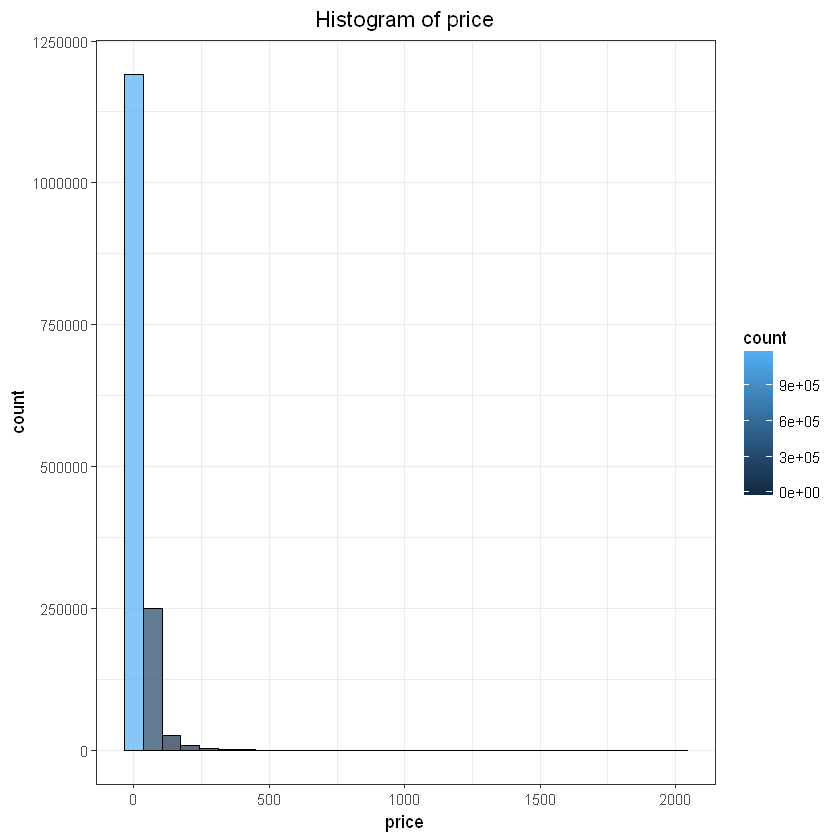

In [9]:
pl <- ggplot(train,aes(price)) + geom_histogram(aes(fill=..count..),color='black',bins  = 30,alpha = 0.7) + theme_bw()
pl + ggtitle('Histogram of price') + theme(plot.title = element_text(hjust = 0.5))


In [89]:
# Ok the plot sizes are too big let's convert them to a smaller size
options(repr.plot.width=5, repr.plot.height=4)

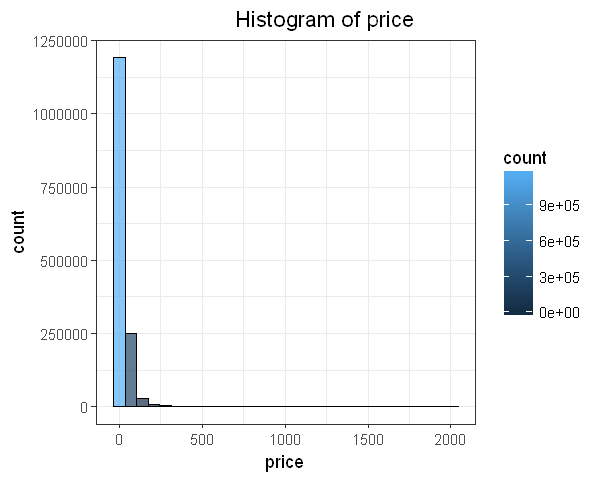

In [32]:
pl <- ggplot(train,aes(price)) + geom_histogram(aes(fill=..count..),color='black',bins  = 30,alpha = 0.7) + theme_bw()
pl + ggtitle('Histogram of price') + theme(plot.title = element_text(hjust = 0.7))


Price is very left-skewed. The minimal price is 0, while the highest is 2009. Let’s transform the Price using log(x+1) to get rid of skewness (the +1 is there to avoid taking log(0)).



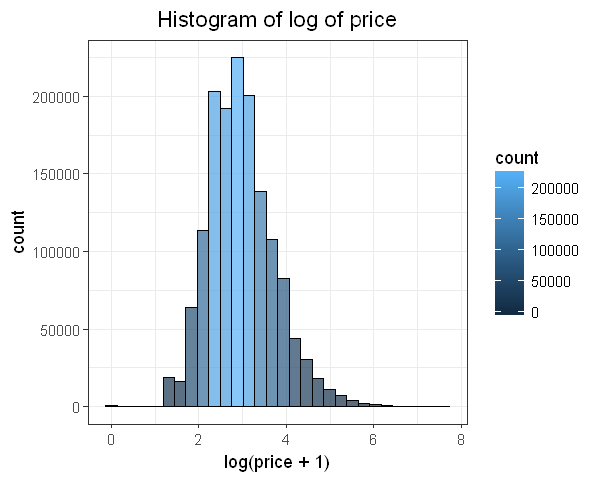

In [30]:
pl2 <- ggplot(train,aes(log(price+1))) + geom_histogram(aes(fill=..count..), color = 'black',bins  = 30,alpha = 0.7) + theme_bw()
pl2 + ggtitle('Histogram of log of price') + theme(plot.title = element_text(hjust = 0.5))


In [18]:
#look like some of the items are given free of cost, now lets look how many items are given away like that
sum(train$price == 0)

[1] 874

In [22]:
#now lets look at the item condition id
range(train$item_condition_id)


[1] 1 5

In [23]:
table(train$item_condition_id)


     1      2      3      4      5 
640549 375479 432161  31962   2384 

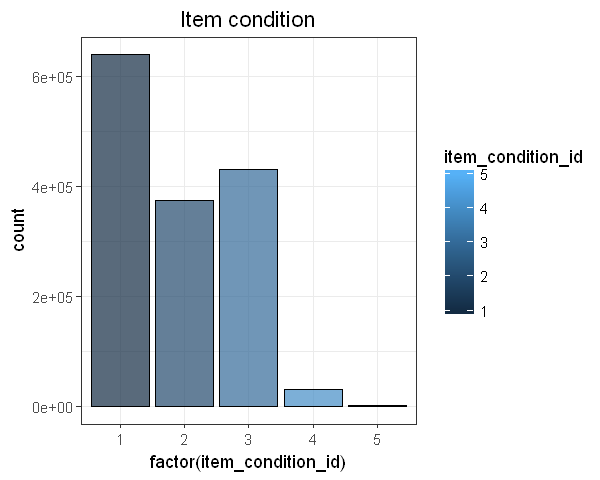

In [33]:
#item with condition 1 is the highest, now let visualize the same
pl3 <- ggplot(train,aes(factor(item_condition_id)))+ geom_bar(aes(fill=item_condition_id),color='black',alpha = 0.7) + theme_bw()
pl3 + ggtitle('Item condition') + theme(plot.title = element_text(hjust = 0.5))

In [43]:
#now let's look at the median prices for item conditions
train[,list(medianprice = median(price)), by = list(item_condition_id)][order(item_condition_id)]


item_condition_id,medianprice
1,18
2,17
3,16
4,15
5,19


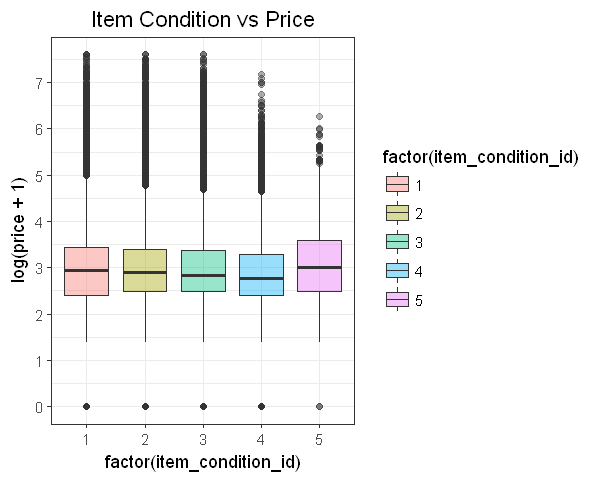

In [29]:
#now lets look at the relationship between item condition and price
options(repr.plot.width=5, repr.plot.height=4)
pl4 <- ggplot(train,aes(factor(item_condition_id),log(price+1)))+ geom_boxplot(aes(fill=factor(item_condition_id)),alpha = 0.4) + theme_bw()
pl4 + scale_y_continuous(breaks = seq(min(0),max(10),by = 1)) + ggtitle('Item Condition vs Price') + theme(plot.title = element_text(hjust = 0.5))


Very interesting to see that condition 5 is having the greater price, upon research could find that item condition 5 is the worst, hence we can relate that branded expensive items that are very old are sold, we'll go through this when we analyze our text data.


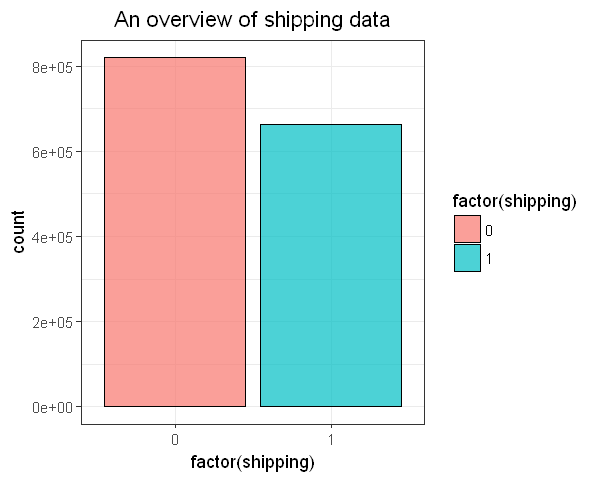

In [34]:
#now lets look at the shipping data
pl5 <- ggplot(train,aes(factor(shipping))) + geom_bar(aes(fill=factor(shipping)),color='black',alpha = 0.7) + theme_bw()
pl5 + ggtitle('An overview of shipping data') + theme(plot.title = element_text(hjust = 0.5))


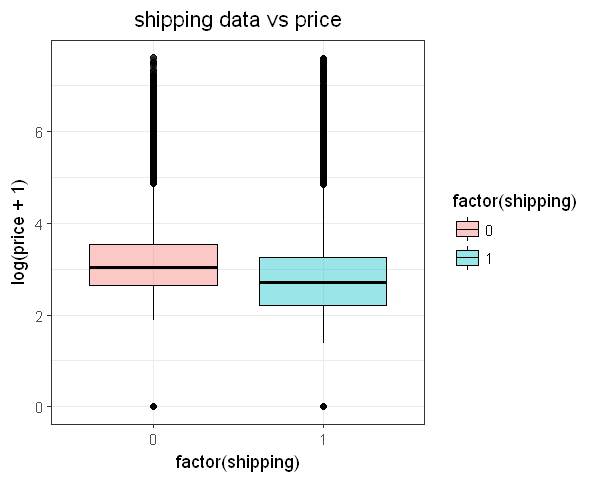

In [35]:
# now let's see the relationship between price and shipping data

pl6 <- ggplot(train,aes(factor(shipping),log(price+1))) + geom_boxplot(aes(fill=factor(shipping)),color='black',alpha = 0.4) + theme_bw()
pl6 + ggtitle('shipping data vs price') + theme(plot.title = element_text(hjust = 0.5))


We assume that if the shipping fee is paid by seller the price to be highbut again interesting to see that it for products where the seller isn't paying the shipping fee is high priced this might be due to the product category and branding etc, we'll explore that in a while.

#relationship between price, shipping and item condition_id


In [ ]:
#now let's see the relationship between price, shipping and item condition_id from above obtained median price.

In [37]:
df <- filter(train,item_condition_id == 5, shipping == 0, price > 19)


In [38]:
head(df)

name,item_condition_id,category_name,brand_name,price,shipping,item_description
Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36,0,No description yet
Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,,24,0,For parts . Turns on and hold battery charge . Read the games perfect .
Nintendo for parts,5,Electronics/Video Games & Consoles/Consoles,,20,0,Powers on but won't play games.
Kd 6 Aunt Pearl size 8,5,Men/Shoes/Athletic,Nike,36,0,Poor conditon kd 6 Aunt pearl. Really beat. Comes with og box
Gamecube NOT READING LOT,5,Electronics/Video Games & Consoles/Games,Nintendo,22,0,"Games do not read. As is condition. Repost of other listing- added 2 more games Rampage and a very very bad condition Pokemon XD. Let me know if you have any questions. For [rm] more I'll include the game cases for Dragonball and Sonic too, just let me know."
Hobo International Lauren Wallet,5,Women/Women's Accessories/Wallets,,24,0,Pretty wallet but the back closing clip is broken. Can probably be repaired by a cobbler. Otherwise this is a very pretty wallet. Price is firm and no free shipping!! Thanks


In [46]:
dim(df)

[1] 782   7

As stated above why are the item's with condition id 5 expensive, so here it is , there are 782 items in that category but are these branded to be so high??

In [47]:
table(df$brand_name == "")


FALSE  TRUE 
  624   158 

yes out of that 624 are branded and the remaining aren't. So it clearly makes sense that 
branded expensive items that are very old are 
sold under category 5


In [48]:
# now lets analyze the category name

length(unique(train$category_name))


[1] 1288

In [49]:
#looks like there are lot of categories
# let's take a look at top ten
sort(table(train$category_name), decreasing = TRUE)[1:10]


             Women/Athletic Apparel/Pants, Tights, Leggings 
                                                      60177 
                              Women/Tops & Blouses/T-Shirts 
                                                      46380 
                                         Beauty/Makeup/Face 
                                                      34335 
                                         Beauty/Makeup/Lips 
                                                      29910 
                   Electronics/Video Games & Consoles/Games 
                                                      26557 
                                         Beauty/Makeup/Eyes 
                                                      25215 
Electronics/Cell Phones & Accessories/Cases, Covers & Skins 
                                                      24676 
                                       Women/Underwear/Bras 
                                                      21274 
                       

In [50]:
#now inorder to proceed further with analysis,let's split the categories
split <- strsplit(train$category_name, split = "/")


In [51]:
cat1 <- sapply(split,'[',1) 


In [52]:
cat2 <- sapply(split,'[',2) 


In [54]:
cat3 <- sapply(split,'[',3) 
cat4 <- sapply(split,'[',4) 
cat5 <- sapply(split,'[',5) 
cat6 <- sapply(split,'[',6) 

In [55]:
train$cat1 <- cat1 
train$cat2 <- cat2
train$cat3 <- cat3 
train$cat4 <- cat4 
train$cat5 <- cat5 
train$cat6 <- cat6

In [56]:
table(cat1)


cat1
                Beauty            Electronics               Handmade 
                207828                 122690                  30842 
                  Home                   Kids                    Men 
                 67871                 171689                  93680 
                 Other      Sports & Outdoors Vintage & Collectibles 
                 45351                  25342                  46530 
                 Women 
                664385 

In [57]:
#ok now since we have successfully splitted, let's see if we have any 'na's' in our category
sum(is.na(train$cat1))


[1] 6327

In [58]:
#yes there exsists hence we shall assign them to a negative value and keep them aside
train$cat1[is.na(train$cat1)] = -1


In [59]:

sum(is.na(train$cat2))


[1] 6327

In [60]:

train$cat2[is.na(train$cat2)] = -1


In [61]:

sum(is.na(train$cat3))


[1] 6327

In [62]:


train$cat3[is.na(train$cat3)] = -1


In [63]:
sum(is.na(train$cat4))


[1] 1478146

In [64]:
sum(is.na(train$cat5))

[1] 1479476

In [65]:
sum(is.na(train$cat6))

[1] 1482535

In [66]:
#table cat4,5,6 contains many NA's hence we drop them
colnames(train)

[1] "name"              "item_condition_id" "category_name"    
 [4] "brand_name"        "price"             "shipping"         
 [7] "item_description"  "cat1"              "cat2"             
[10] "cat3"              "cat4"              "cat5"             
[13] "cat6"

In [67]:
train <- train[,-c(11,12,13)]


In [68]:
colnames(train)

[1] "name"              "item_condition_id" "category_name"    
 [4] "brand_name"        "price"             "shipping"         
 [7] "item_description"  "cat1"              "cat2"             
[10] "cat3"

In [69]:
# so now we have 3 categories, now let's start analyzing them


In [70]:
#when it comes to analyzing Hierarchical structures Tree maps stand out to be the best
#setting the size for tree maps
options(repr.plot.width=7, repr.plot.height=7)


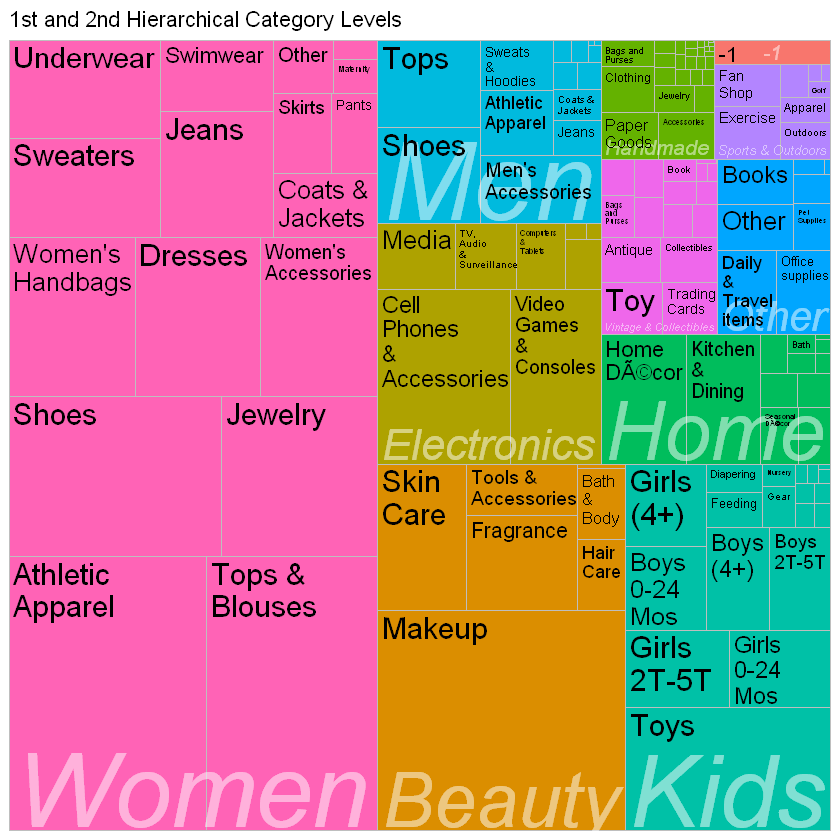

In [71]:
#now let's start of with 1st and 2nd categories
train %>% group_by(cat1, cat2) %>% count() %>% ungroup() %>% ggplot(aes(area=n, fill=cat1, label=cat2, subgroup=cat1)) +
geom_treemap() + geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour = "white", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "black", place = "topleft", reflow = T) + theme(legend.position = "null") +
ggtitle("1st and 2nd Hierarchical Category Levels")

It's evident that Women and Men form the most, hence let's start analyzing them.

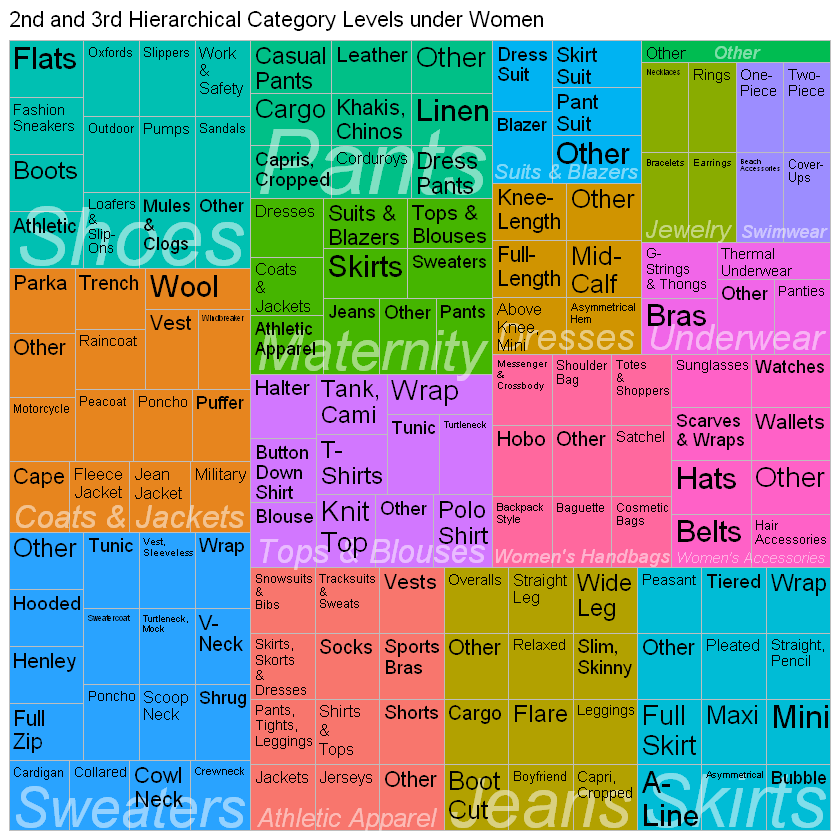

In [72]:
train[cat1 =="Women", .N, by = list(cat2, cat3)] %>% group_by(cat2, cat3) %>% count() %>% ungroup() %>% ggplot(aes(area=n, fill=cat2, label=cat3, subgroup=cat2)) +
geom_treemap() + geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour = "white", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "black", place = "topleft", reflow = T) + theme(legend.position = "null") +
ggtitle("2nd and 3rd Hierarchical Category Levels under Women")

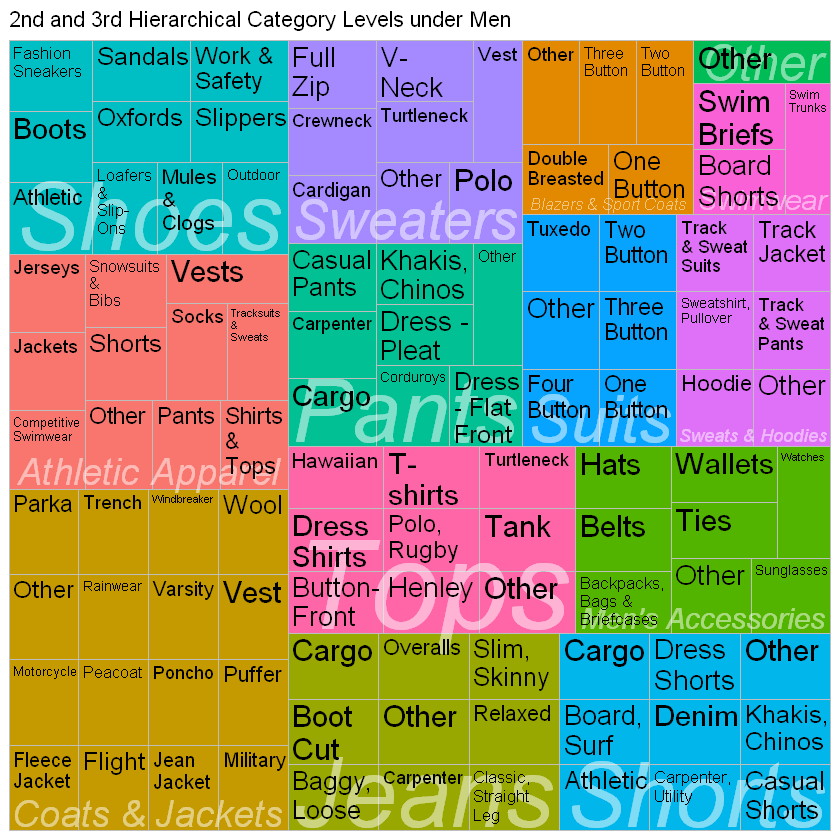

In [74]:
train[cat1=='Men',.N, by = list(cat2,cat3)] %>% group_by(cat2,cat3) %>% count %>% ungroup() %>% ggplot(aes(area=n, fill=cat2, label=cat3, subgroup=cat2)) +
geom_treemap() + geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour = "white", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "black", place = "topleft", reflow = T) + theme(legend.position = "null") +
ggtitle("2nd and 3rd Hierarchical Category Levels under Men")

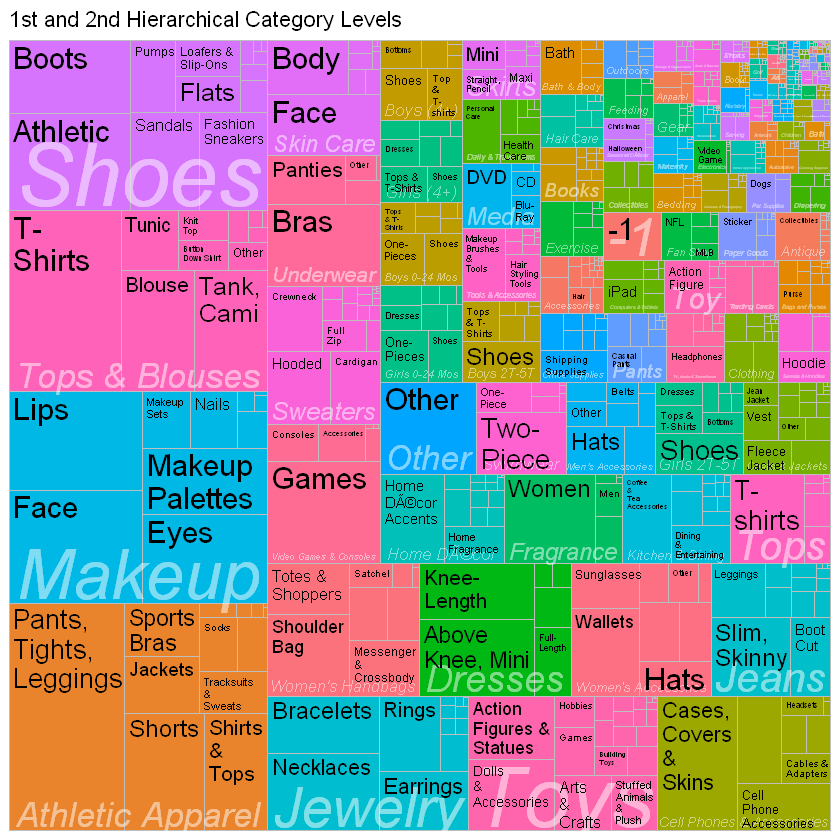

In [75]:
train %>% group_by(cat2, cat3) %>% count() %>% ungroup() %>% ggplot(aes(area=n, fill=cat2, label=cat3, subgroup=cat2)) +
geom_treemap() + geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour = "white", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "black", place = "topleft", reflow = T) + theme(legend.position = "null") +
ggtitle("2nd and 3rd Hierarchical Category Levels")

In [76]:
str(train)

Classes 'data.table' and 'data.frame':	1482535 obs. of  10 variables:
 $ name             : chr  "MLB Cincinnati Reds T Shirt Size XL" "Razer BlackWidow Chroma Keyboard" "AVA-VIV Blouse" "Leather Horse Statues" ...
 $ item_condition_id: int  3 3 1 1 1 3 3 3 3 3 ...
 $ category_name    : chr  "Men/Tops/T-shirts" "Electronics/Computers & Tablets/Components & Parts" "Women/Tops & Blouses/Blouse" "Home/Home DÃ©cor/Home DÃ©cor Accents" ...
 $ brand_name       : chr  "" "Razer" "Target" "" ...
 $ price            : num  10 52 10 35 44 59 64 6 19 8 ...
 $ shipping         : int  1 0 1 1 0 0 0 1 0 0 ...
 $ item_description : chr  "No description yet" "This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work"| __truncated__ "Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!" "New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being

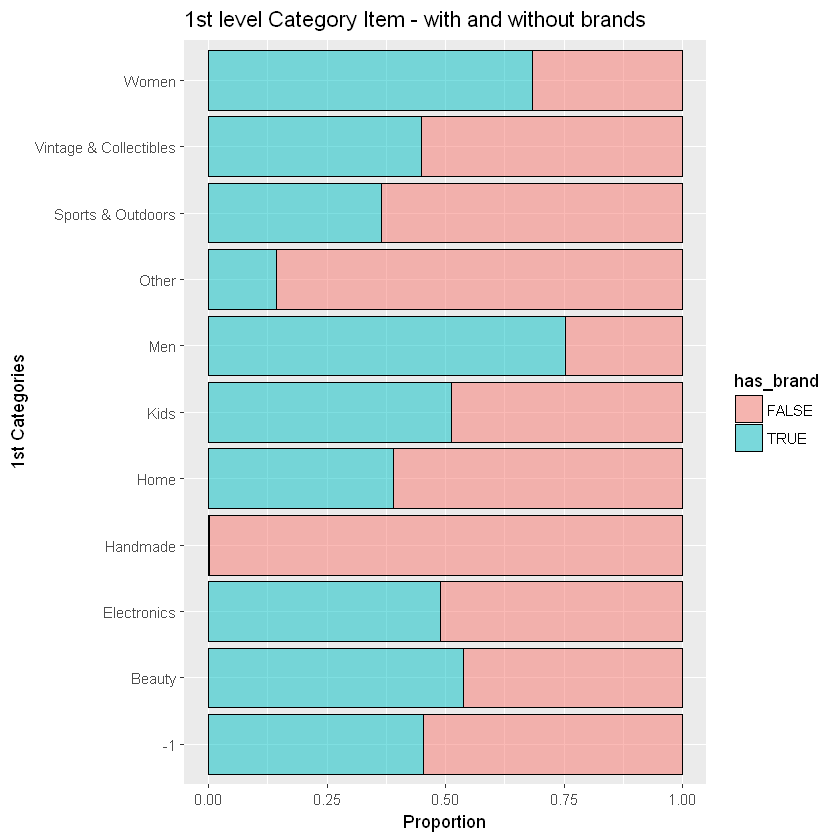

In [77]:
# so now let's start with brand analysis
train[, has_brand := (brand_name!='')] %>% 
ggplot(aes(x=cat1, fill=has_brand)) +geom_bar(position='fill',alpha = 0.5, color='black') +xlab('1st Categories') + coord_flip() +
ylab('Proportion') + ggtitle('1st level Category Item - with and without brands')




We can see that most of the Mens and Womens items have  a brand while handmade items do not have one, which clearly makes sense

In [79]:
#Now let's take a look at top 20 most sold brands and their Categories

top20 <- train[brand_name !="", .N, by = list(bName = brand_name)][order(N, decreasing = T)][1:20]



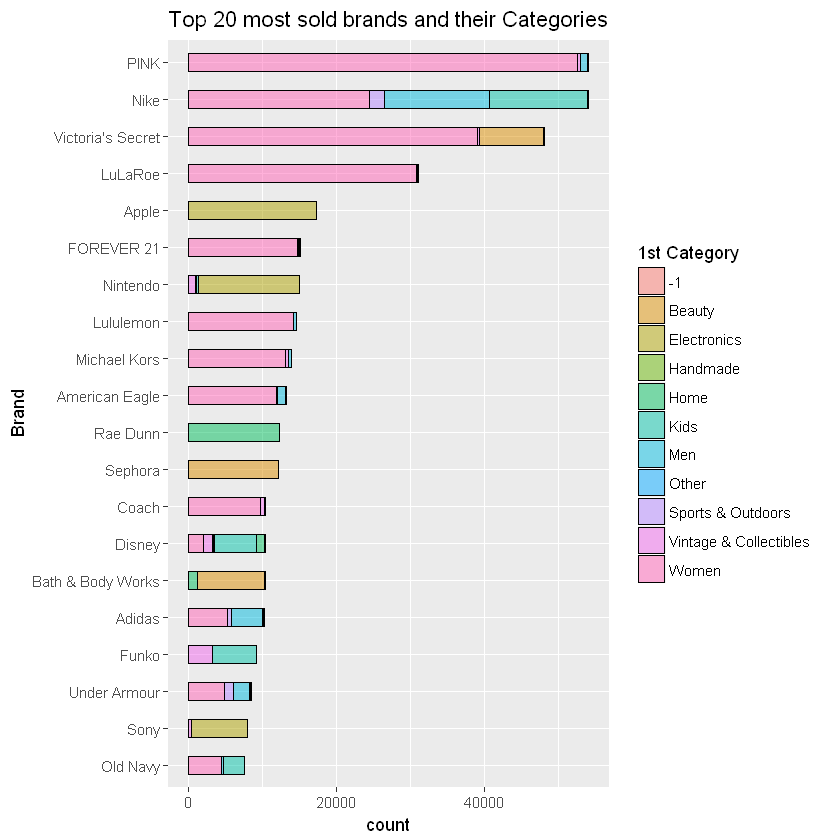

In [81]:
train[brand_name %in% top20$bName] %>% ggplot(aes(x=factor(brand_name, levels=rev(top20$bName)), fill=cat1)) +
geom_bar(width=0.5,alpha=0.5, color='black') + coord_flip() + xlab('Brand') +labs(fill='1st Category') +
ggtitle('Top 20 most sold brands and their Categories') + theme(plot.title = element_text(hjust = 0.5))


We can see that most of the brands such as "PINK","VICTORIAS SECRET", "NIKE" and "LULA ROE" are mostly sold by women

In [ ]:
Before getting into Item-Description, let us analyze names

In [82]:
#top 20 names mostl used
top20name <- train[name !="", .N, by = list(Name = name)][order(N, decreasing = T)][1:20]



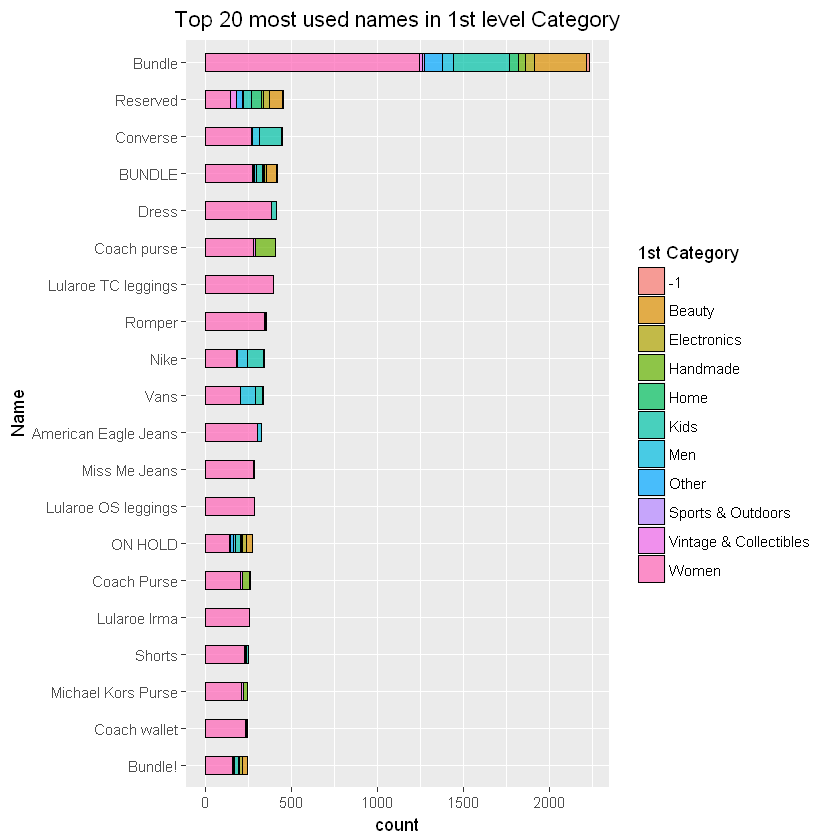

In [86]:
train[name %in% top20name$Name] %>% ggplot(aes(x=factor(name, levels=rev(top20name$Name)))) +
  geom_bar(aes(fill=cat1),width=0.5,alpha=0.7, color='black') + coord_flip() + xlab('Name') +labs(fill='1st Category') +
  ggtitle('Top 20 most used names in 1st level Category') + theme(plot.title = element_text(hjust = 0.5))


So clearly this gives us an insight of what 'Name' consists of how this feature can be used in modelling.

Now we are half way around and we are still clueless of these affect prices as we cannot see a good relationship with the target.

Now let's proceed with Bivariate analysis.

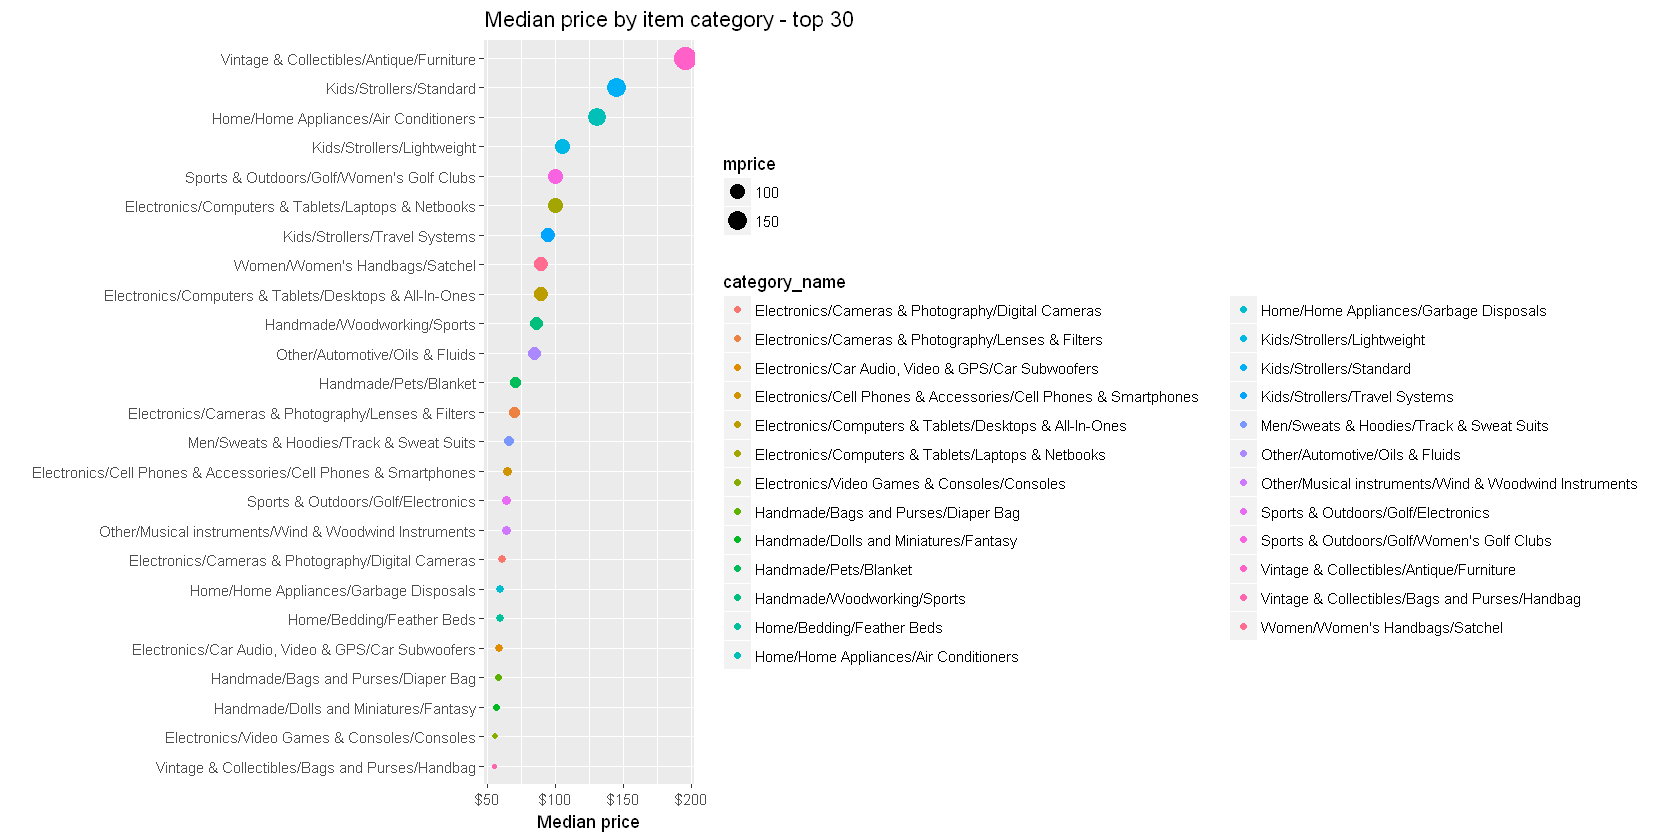

In [122]:
options(repr.plot.width=14, repr.plot.height=7)
train[, .(mprice = median(price)), by = category_name][order(mprice, decreasing = TRUE)][1:25] %>%
ggplot(aes(x = reorder(category_name, mprice),y = mprice)) + geom_point(aes(color=category_name,size = mprice)) +
labs(x = '', y = 'Median price',title = 'Median price by item category - top 30') + scale_y_continuous(labels = scales::dollar) + coord_flip()


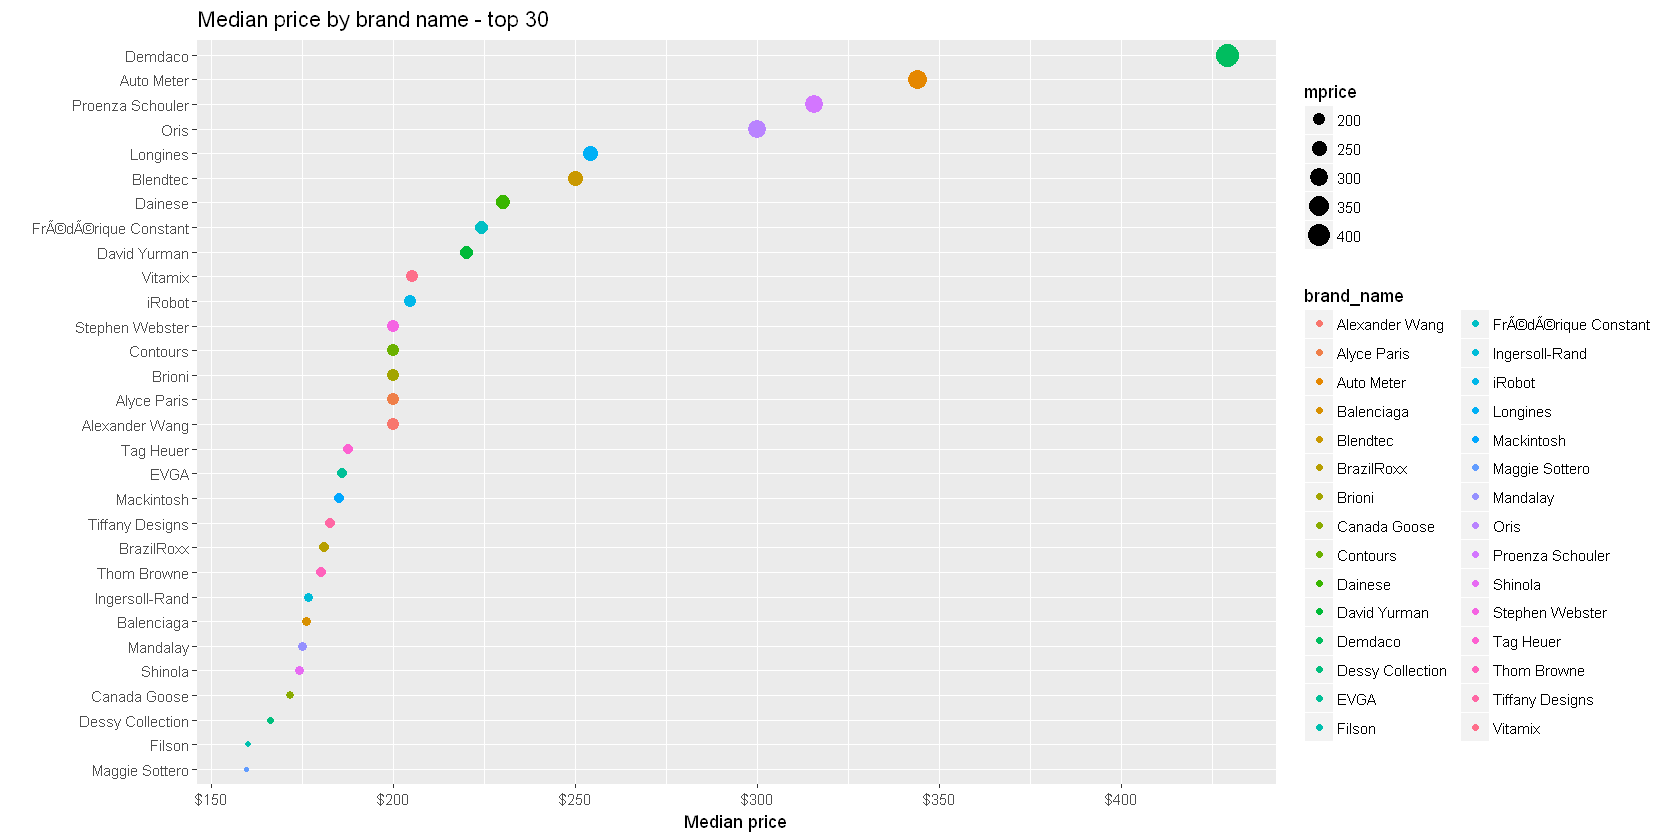

In [121]:

train[, .(mprice = median(price)), by = brand_name][order(mprice, decreasing = TRUE)][1:30] %>%
ggplot(aes(x = reorder(brand_name, mprice),y = mprice)) + geom_point(aes(color=brand_name,size = mprice)) +
labs(x = '', y = 'Median price',title = 'Median price by brand name - top 30') + scale_y_continuous(labels = scales::dollar) + coord_flip()


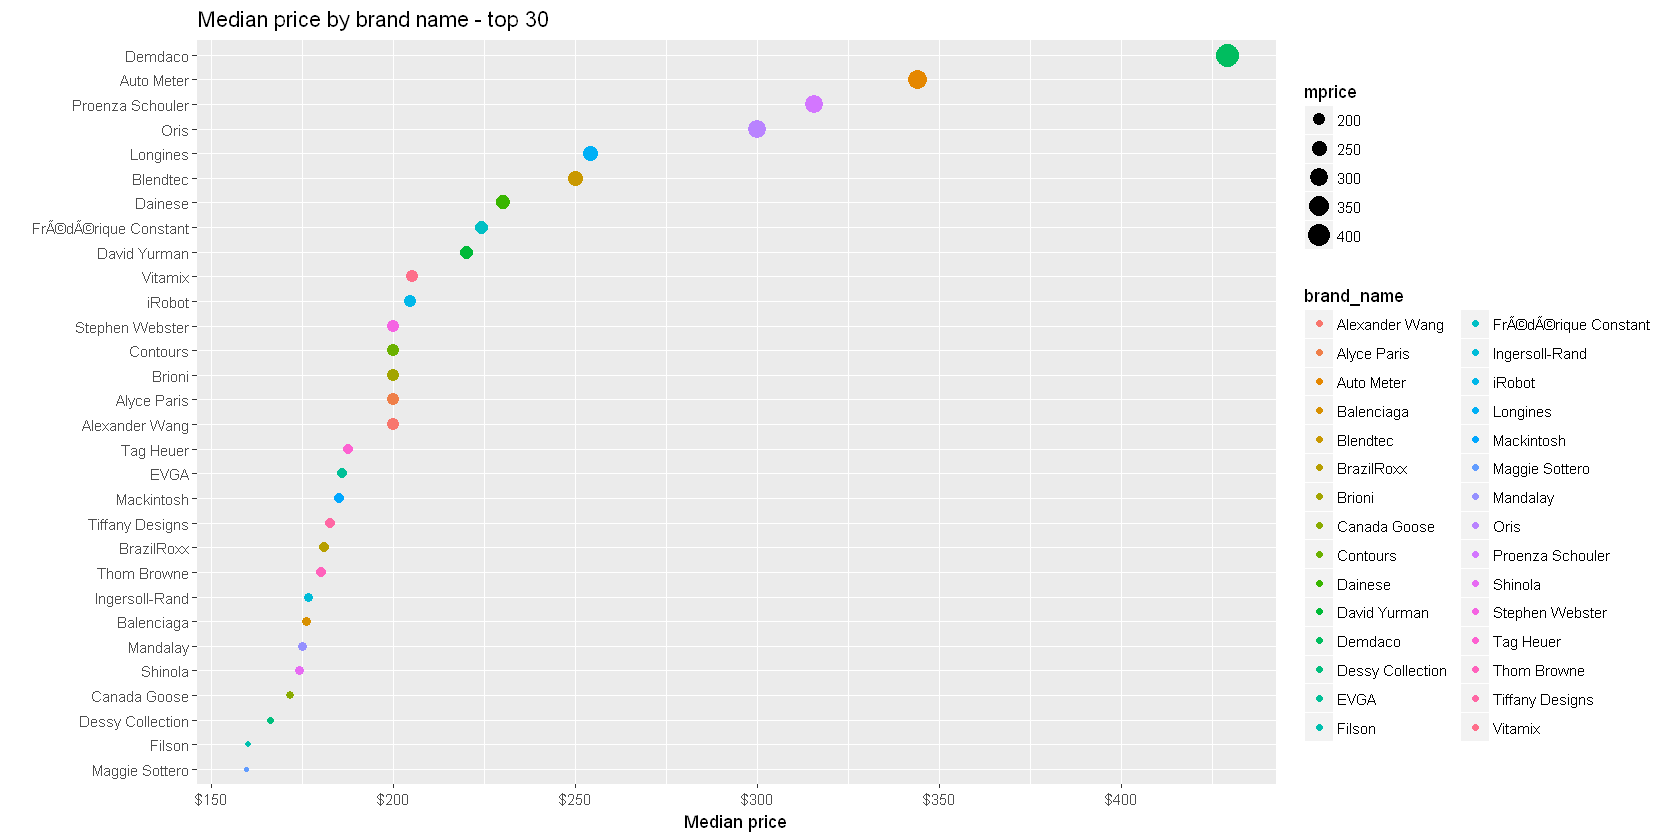

In [103]:
train[, .(mprice = median(price)), by = brand_name][order(mprice, decreasing = TRUE)][1:30] %>%
ggplot(aes(x = reorder(brand_name, mprice),y = mprice)) + geom_point(aes(color=brand_name,size = mprice)) +
labs(x = '', y = 'Median price',title = 'Median price by brand name - top 30') + scale_y_continuous(labels = scales::dollar) + coord_flip()



As seen from above we saw  how cateogries, name, brand name influence price
categories, brand name and name  are contributing so much into the response variable 'price'

Now since we know that major information should be in "category_name", "brand_name", "item_description" "name" of the item. So, 
We shall do feature engineering to extract a few variables from these three variables.
 

In [16]:
#now we load the  test set
test <- fread('mercaritest.tsv', sep = '\t')

Read 693359 rows and 7 (of 7) columns from 0.144 GB file in 00:00:04


In [18]:
#now here comes the challenge, filling in the zero priced items, these items can significantly have an impact on our model
sum(train$price == 0)

[1] 874

In [19]:
#so there are 874 rows with zero priced items which is a small amount when compared to the dataset, now lets drop them
train <- train[train$price > 0]

In [20]:
sum(train$price == 0)

[1] 0

In [21]:
range(train$price)

[1]    3 2009

In [22]:
# now let's create a new variable log(price) which will help in our analysis later
train$log_price <- log(train$price, base=exp(1))

In [23]:
sum(is.na(test))

[1] 0

So that's once again great to have no na's. Lets move on.

In [130]:
#system was damn slow hence performing garbage collection
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6675335,356.6,9968622,532.4,9968622,532.4
Vcells,99971680,762.8,162874901,1242.7,162807314,1242.2


In [24]:
colnames(train)[1] <- 'id'

In [25]:
colnames(test)[1] <- 'id'

In [28]:
target.train <- train[,c(6,9)]  #These two columns are the target variables,shall add back later for analysis.


In [29]:
mercari.train <- train[,-c(6,9)]

In [31]:
mercari.df <- rbind(mercari.train, test, fill=TRUE)

In [32]:
#Checking if there is any missing data
colSums(sapply(mercari.df, is.na))

id              name item_condition_id     category_name 
                0                 0                 0                 0 
       brand_name          shipping  item_description 
                0                 0                 0

In [33]:
#now let's analyze the item_desc coloumn
mercari_desc <- table(mercari.train[,7])
mercari_desc <- data.frame(mercari_desc)

In [34]:
colnames(mercari_desc) <- c("desc", "freq")
mercari_desc <- mercari_desc[order(mercari_desc$freq, decreasing=TRUE),]
head(mercari_desc)

,desc,freq
823132,No description yet,82427
743636,New,4099
245681,Brand new,3056
502649,Good condition,1272
520293,Great condition,1158
643985,Like new,986


# 3> TEXT PROCESSING AND EXPLORATION

Warning message in wordcloud(words = mercari_desc_cloud$desc, freq = mercari_desc_cloud$freq, :
"âš ï¸PLEASE READâš ï¸ â€¼ï¸Orders will be shipped next day â€¼ï¸Delivery takes 3 to 5 business days â€¼ï¸Price is Firm â€¢100% UV Protection (UVA and UVB) â€¢Clear Lens Glasses â€¢For fashion use â€¢NON-RX (non-prescription) â€¢Great for daily use! could not be fit on page. It will not be plotted."Warning message in wordcloud(words = mercari_desc_cloud$desc, freq = mercari_desc_cloud$freq, :
"TRACK YOUR PACKAGE We usually ship within 2 days of purchase. You will receive a tracking # as soon as we ship. ALL ITEMS AVAILABLE **All are items are available for purchase, if it's listed , we have it! SAVE ON SHIPPING **Save on shipping ! We will bundle items for you, just let us know what you want :) The more you buy the bigger discount I can give on the items that I ship together. CHECK OUT ALL OUR COOL ITEMS! We carry xbox original xbox 360 - Playstation 1 - playstation 2 - playstation 3 - 

"Durable & High quality products! FAST & FREE SHIPPING! Bundle deals are available upon request! This item is brand new, never used, and comes in original packaging! could not be fit on page. It will not be plotted."Warning message in wordcloud(words = mercari_desc_cloud$desc, freq = mercari_desc_cloud$freq, :
"BRAND NEW , HIGH QUALITY rubber case ( Unlike any other cheap plastic cases are selling here ) Ship out within 1-2 days and Shipping takes 4-5 days with tracking# . please make sure your shipping address is correct after pay . FIRM MEAN FIRM , I'll IGNORE your OFFER and DELETE . *PLEASE DONT ASK FOR LOWER FREE SHIPPING, SHIP SAME DAY Contact me for bundle 2 cases or more TO SAVE $$ 1 case [rm] 2 cases [rm] 3 cases [rm] PLEASE SEND ME A MESSAGE FOR YOUR PHONE SIZE AFTER PAY . *I also have it Available for the phone below == iPhone 6/6S , iPhone 6 Plus/6S plus , Iphone SE/ 5/5S , iPhone 5C , iPhone 4/4S , IPod Touch 5. Samsung Galaxy Note 5 , Note 4 , Note 3 , Note 2 N7100 , Samsu

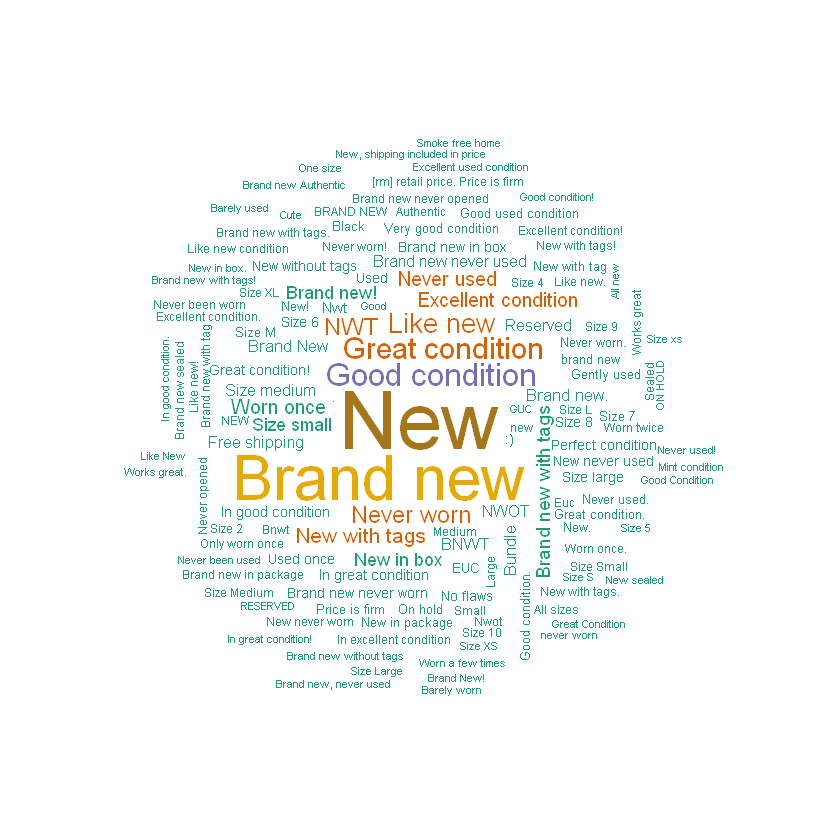

In [35]:
mercari_desc_cloud <- mercari_desc[c(2:150),] 
#As the wordcloud has limitation on no. of character, you would see some error below

wordcloud(words = mercari_desc_cloud$desc, freq = mercari_desc_cloud$freq, min.freq = 1,
          max.words=500, random.order=FALSE, rot.per=0.1, 
          colors=brewer.pal(7, "Dark2"))

In [36]:
# now let's analyze the same for name
train_name <- table(mercari.train[,2])
train_name <- data.frame(train_name)

In [37]:
colnames(train_name) <- c("desc", "freq")
train_name <- train_name[order(train_name$freq, decreasing=TRUE),]
head(train_name)

,desc,freq
245542,Bundle,2232
945265,Reserved,453
310431,Converse,445
245543,BUNDLE,418
353820,Dress,410
301885,Coach purse,404


Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Miss me jeans could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Lularoe TC Leggings could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Nike shoes could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"American eagle jeans could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Michael Kors could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Lularoe OS Leggings could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_

"Nike hoodie could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Bodysuit could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Fidget spinner could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"American eagle shorts could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Nike Hoodie could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Jacket could not be fit on page. It will not be plotted."Warning message in wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, :
"Pink could not be fit on page. It will not be plotted."Warning m

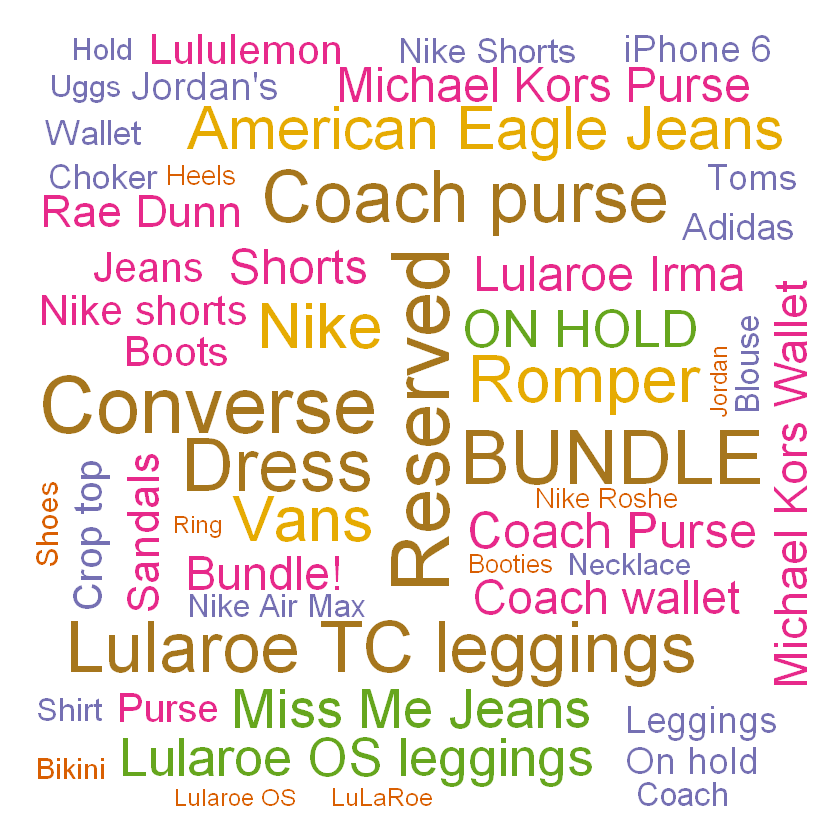

In [38]:
train_name_cloud <- train_name[c(2:150),] 
#As the wordcloud has limitation on no. of character, you would see some error below

wordcloud(words = train_name_cloud$desc, freq = train_name_cloud$freq, min.freq = 1,
          max.words=300, random.order=FALSE, rot.per=0.1, 
          colors=brewer.pal(7, "Dark2")) 

In [39]:
#now let's convert item_desc,brand name, category and name to upper case 
mercari.df$item_description <- toupper(mercari.df$item_description)


In [40]:
mercari.df$category_name <- toupper(mercari.df$category_name)

In [41]:
mercari.df$brand_name <- toupper(mercari.df$brand_name)

In [42]:
mercari.df$name <- toupper(mercari.df$name)

In [43]:
#now lets factor them
mercari.df$item_description <- as.factor(mercari.df$item_description)


In [44]:
mercari.df$category_name <- as.factor(mercari.df$category_name)


In [45]:
mercari.df$name <- as.factor(mercari.df$name)

In [46]:
mercari.df$brand_name <- as.factor(mercari.df$brand_name)

In [47]:
colnames(mercari.df)[7]

[1] "item_description"

In [49]:
mercari.df2 <- mercari.df[,-7] # we shall seperate this aside for now
#colnames(mercari.train)

Now since we know that the major information should be in 
"category_name", "brand_name", "item_description" of the item. So we will split a few variables from these three variables.

#FEATURE ENGINEERING



In [50]:
mr.fn <- mercari.df[,c(4,5,7)]


In [51]:
colnames(mr.fn)

[1] "category_name"    "brand_name"       "item_description"

In [52]:
class(mr.fn)

[1] "data.table" "data.frame"

In [54]:
mr.fn <- as.data.frame(mr.fn)
colnames(mr.fn)

[1] "category_name"    "brand_name"       "item_description"

In [55]:
colnames(mr.fn) <- c('cat','brand','desc')

In [56]:
str(mr.fn)

'data.frame':	2175020 obs. of  3 variables:
 $ cat  : Factor w/ 1311 levels "","BEAUTY/BATH & BODY/BATH",..: 831 88 1279 505 1206 1218 1278 910 910 1047 ...
 $ brand: Factor w/ 5288 levels "","!IT JEANS",..: 1 3945 4648 1 1 1 57 4410 3390 1 ...
 $ desc : Factor w/ 1850300 levels "","'","'''TIS THE SEASON FOR RAIN! NEVER USED JUST STORED AWAY. FLOWERS AROUND THE ENTIRE UMBRELLA.",..: 1188509 1639687 183956 1147772 564184 254143 1472423 1842792 718395 834558 ...


From the above tree diagrams, bargraphs and wordclouds the most frequently used terms are known, hence by using them lets extract few of them from mr.fn.Below shown parts will extract the information from "item_description", "category_name","brand_name" and "name".Most of the item have only 3 level's in "category_name". Less than 5000 cases have more than 3 level. Since the proportion is really small,as shown above earlier we have dropped the 4th, 5th level of "category_name" of that 5000 records.

# 4> DATA PREPARATION FOR MODELLING

In [57]:
mr.fn$beauty <- ifelse(grepl("BEAUTY", mr.fn$cat)|grepl("BEAUTY", mr.fn$desc),1,0)
mr.fn$electronic <- ifelse(grepl("ELECTRONIC", mr.fn$cat)|grepl("ELECTRONIC", mr.fn$desc),1,0)
mr.fn$handmade <- ifelse(grepl("HANDMADE", mr.fn$cat)|grepl("HANDMADE", mr.fn$desc)|
                         grepl("DIY", mr.fn$cat)|grepl("DIY", mr.fn$desc),1,0)
mr.fn$home <- ifelse(grepl("HOME", mr.fn$cat)|grepl("HOME", mr.fn$desc)|
                      grepl("HOUSE", mr.fn$cat)|grepl("HOUSE", mr.fn$desc),1,0)
mr.fn$kid <- ifelse(grepl("KID", mr.fn$cat)|grepl("KID", mr.fn$desc)|
                     grepl("BOY", mr.fn$cat)|grepl("BOY", mr.fn$desc)|
                     grepl("GIRL", mr.fn$cat)|grepl("GIRL", mr.fn$desc)|
                     grepl("CHILD", mr.fn$cat)|grepl("CHILD", mr.fn$desc),1,0) 
mr.fn$women <- ifelse((grepl("WOMEN", mr.fn$cat)|grepl("WOMEN", mr.fn$desc)),1,0)
mr.fn$men <- ifelse(((!grepl("WOMEN", mr.fn$cat)) & (grepl("MEN", mr.fn$cat)))|
                     ((!grepl("WOMEN", mr.fn$desc)) & (grepl("MEN", mr.fn$desc))),1,0)
mr.fn$athletic <- ifelse(grepl("ATHLETIC", mr.fn$cat)|grepl("ATHLETIC", mr.fn$desc)|
                          grepl("SPORT", mr.fn$cat)|grepl("SPORT", mr.fn$desc),1,0)
mr.fn$wine <- ifelse(grepl("WINE", mr.fn$cat)|grepl("WINE", mr.fn$desc)|
                      grepl("VINTAGE", mr.fn$cat)|grepl("VINTAGE", mr.fn$desc)|
                      grepl("ALCOCHOL", mr.fn$cat)|grepl("ALCOHOL", mr.fn$desc),1,0)



In [58]:
mr.fn$athletic_apparel <- ifelse(grepl("ATHLETIC APPAREL", mr.fn$cat)|grepl("ATHLETIC APPAREL", mr.fn$desc),1,0)
mr.fn$makeup <- ifelse(grepl("MAKEUP", mr.fn$cat)|grepl("MAKEUP", mr.fn$desc),1,0)
mr.fn$blouse <- ifelse(grepl("BLOUSE", mr.fn$cat)|grepl("BLOUSE", mr.fn$desc),1,0)
mr.fn$shoes <- ifelse(grepl("SHOE", mr.fn$cat)|grepl("SHOE", mr.fn$desc),1,0)
mr.fn$toy <- ifelse(grepl("TOY", mr.fn$cat)|grepl("TOY", mr.fn$desc),1,0)
mr.fn$jewelry <- ifelse(grepl("JEWELRY", mr.fn$cat)|grepl("JEWELRY", mr.fn$desc),1,0)
mr.fn$phone <- ifelse(((!grepl("ACCESSORIES", mr.fn$cat)) & (grepl("PHONE", mr.fn$cat)))|
                        ((!grepl("ACCESSORIES", mr.fn$desc)) & (grepl("PHONE", mr.fn$desc))),1,0)
mr.fn$bag <- ifelse(grepl("BAG", mr.fn$cat)|grepl("BAG", mr.fn$desc),1,0)
mr.fn$dress <- ifelse(grepl("DRESS", mr.fn$cat)|grepl("DRESS", mr.fn$desc),1,0)
mr.fn$pant <- ifelse(grepl("PANT", mr.fn$cat)|grepl("PANT", mr.fn$desc)|
                       grepl("JEAN", mr.fn$cat)|grepl("JEAN", mr.fn$desc),1,0)
mr.fn$accessories <- ifelse(((!grepl("PHONE", mr.fn$cat)) & (grepl("ACCESSORIES", mr.fn$cat)))|
                              ((!grepl("PHONE", mr.fn$desc)) & (grepl("ACCESSORIES", mr.fn$desc))),1,0)
mr.fn$luxury <- ifelse(grepl("WATCH", mr.fn$cat)|grepl("WATCH", mr.fn$desc)|
                         grepl("JEWELRY", mr.fn$cat)|grepl("JEWELRY", mr.fn$desc)|
                         grepl("RING", mr.fn$cat)|grepl("RING", mr.fn$desc)|
                         grepl("BRACELETS", mr.fn$cat)|grepl("BRACELETS", mr.fn$desc),1,0)



In [59]:
str(mr.fn) # Verifying to see if the output obtained is of numeric

'data.frame':	2175020 obs. of  24 variables:
 $ cat             : Factor w/ 1311 levels "","BEAUTY/BATH & BODY/BATH",..: 831 88 1279 505 1206 1218 1278 910 910 1047 ...
 $ brand           : Factor w/ 5288 levels "","!IT JEANS",..: 1 3945 4648 1 1 1 57 4410 3390 1 ...
 $ desc            : Factor w/ 1850300 levels "","'","'''TIS THE SEASON FOR RAIN! NEVER USED JUST STORED AWAY. FLOWERS AROUND THE ENTIRE UMBRELLA.",..: 1188509 1639687 183956 1147772 564184 254143 1472423 1842792 718395 834558 ...
 $ beauty          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ electronic      : num  0 1 0 0 0 0 0 0 0 0 ...
 $ handmade        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ home            : num  0 0 0 1 0 0 0 0 0 0 ...
 $ kid             : num  0 0 0 0 0 0 0 1 1 0 ...
 $ women           : num  0 0 1 0 1 1 1 0 0 0 ...
 $ men             : num  1 0 0 0 0 0 0 0 0 0 ...
 $ athletic        : num  0 0 0 0 0 0 0 1 1 0 ...
 $ wine            : num  0 0 0 0 0 0 0 0 0 1 ...
 $ athletic_apparel: num  0 0 0 0 0 0 0 0 0 0 ...
 

In [60]:
mr.fn$tshirt <- ifelse(grepl("T-SHIRT", mr.fn$cat)|grepl("T-SHIRT", mr.fn$desc)|
                         grepl("TSHIRT", mr.fn$cat)|grepl("TSHIRT", mr.fn$desc),1,0)
mr.fn$face <- ifelse(grepl("FACE", mr.fn$cat)|grepl("FACE", mr.fn$desc),1,0)
mr.fn$game <- ifelse(grepl("GAME", mr.fn$cat)|grepl("GAME", mr.fn$desc),1,0)
mr.fn$lip <- ifelse(grepl("LIP", mr.fn$cat)|grepl("LIP", mr.fn$desc),1,0)
mr.fn$eye <- ifelse(grepl("EYE", mr.fn$cat)|grepl("EYE", mr.fn$desc),1,0)
mr.fn$care <- ifelse(grepl("CARE", mr.fn$cat)|grepl("CARE", mr.fn$desc),1,0)
mr.fn$top <- ifelse(grepl("TOP", mr.fn$cat)|grepl("TOP", mr.fn$desc),1,0)

In [61]:
mr.fn$pink <- ifelse(grepl("PINK", mr.fn$brand),1,0)
mr.fn$secret <- ifelse(grepl("VICTORIA'S SECRET", mr.fn$brand)|grepl("VICTORIA'S SECRET", mr.fn$desc),1,0)
mr.fn$nike <- ifelse(grepl("NIKE", mr.fn$brand)|grepl("NIKE", mr.fn$desc),1,0)
mr.fn$apple <- ifelse(grepl("APPLE", mr.fn$brand)|grepl("APPLE", mr.fn$desc)|
                        grepl("MAC", mr.fn$brand)|grepl("MAC", mr.fn$desc)|
                        grepl("IPHONE", mr.fn$desc)|grepl("I PHONE", mr.fn$desc)|
                        grepl("IPAD", mr.fn$desc)|grepl("I PAD", mr.fn$desc),1,0)
mr.fn$lularoe <- ifelse(grepl("LULAROE", mr.fn$brand)|grepl("LULAROE", mr.fn$desc),1,0)



In [62]:
mr.fn$size <- ifelse((grepl("SMALL", mr.fn$desc)|grepl("MEDIUM", mr.fn$desc)|
                        grepl("LARGE", mr.fn$desc)|grepl("XL", mr.fn$desc)|
                        grepl("XS", mr.fn$desc)|grepl("SIZE", mr.fn$desc)|
                        grepl("INCH", mr.fn$desc)),1,0)

mr.fn$color <- ifelse((grepl("RED", mr.fn$desc)|grepl("YELLOW", mr.fn$desc)|
                         grepl("BLUE", mr.fn$desc)|grepl("GREEN", mr.fn$desc)|
                         grepl("WHITE", mr.fn$desc)|grepl("BLACK", mr.fn$desc)|
                         grepl("DULL", mr.fn$desc)|grepl("GREY", mr.fn$desc)|
                         grepl("BROWN", mr.fn$desc)|grepl("PURPLE", mr.fn$desc)|
                         grepl("COLOR", mr.fn$desc)|grepl("COLOUR", mr.fn$desc)),1,0)  

mr.fn$leather <- ifelse(grepl("LEATHER", mr.fn$desc),1,0)

mr.fn$new <- 0 #without age information
mr.fn$new[grepl("NEW", mr.fn$desc)|grepl("NEVER", mr.fn$desc)|
            grepl("BNWT", mr.fn$desc)|grepl("NWT", mr.fn$desc)] <- 2 #New
mr.fn$new[grepl("ONCE", mr.fn$desc)|grepl("TWICE", mr.fn$desc)|
            (grepl("WORN", mr.fn$desc)&(!grepl("NEVER WORN", mr.fn$desc)))] <- 1 #Nearly New

mr.fn$desc <- as.character(mr.fn$desc)
mr.fn$len_des <- 1 #With description shorter or equal to 50 character
mr.fn$len_des[nchar(mr.fn$desc)>60] <- 2 #With description more than 50 character
mr.fn$len_des[grepl("NO DESCRIPTION YET", mr.fn$desc)] <- 0 #no description
mr.fn$desc <- as.factor(mr.fn$desc)

mr.fn$cond <- 0
mr.fn$cond[grepl("GOOD CONDITION", mr.fn$desc)|grepl("GREAT CONDITION", mr.fn$desc)] <- 1
mr.fn$cond[grepl("EXCELLENT CONDITION", mr.fn$desc)|grepl("PERFECT CONDITION", mr.fn$desc)] <-2


mr.fn$tags <- ifelse(grepl("WITH TAG", mr.fn$desc)|grepl("BNWT", mr.fn$desc)|grepl("NWT", mr.fn$desc),1,0)
mr.fn$no_tags <- ifelse(grepl("WITHOUT TAG", mr.fn$desc)|grepl("NO TAG", mr.fn$desc),1,0)



In [63]:
mr.fn$bundle <- ifelse(grepl("BUNDLE", mr.fn$name)|grepl("BUNDLE", mr.fn$desc),1,0)
mr.fn$lularoe <- ifelse(grepl("LULAROE", mr.fn$name)|grepl("LULAROE", mr.fn$desc),1,0)
mr.fn$coach <- ifelse(grepl("COACH", mr.fn$name)|grepl("COACH", mr.fn$desc),1,0)

mr.fn$americaneagle <- ifelse(grepl("AMERICAN", mr.fn$name)|grepl("AMERICAN", mr.fn$desc)|
                                grepl("EAGLE", mr.fn$name)|grepl("EAGLE", mr.fn$desc),1,0)
mr.fn$missme <- ifelse(grepl("MISS ME", mr.fn$name)|grepl("MISS ME", mr.fn$desc),1,0)

mr.fn$reserved <- ifelse((grepl("RESERVED", mr.fn$name)|grepl("RESERVED", mr.fn$desc)),1,0)

mr.fn$onhold <- ifelse(grepl("ON HOLD", mr.fn$name)|grepl("ON HOLD", mr.fn$desc),1,0)

mr.fn$michaekors <- ifelse(grepl("MICHAEL", mr.fn$name)|grepl("MICHAEL", mr.fn$desc)|
                grepl("KORS", mr.fn$name)|grepl("KORS", mr.fn$desc)|
mr.fn$converse <- ifelse(grepl("CONVERSE", mr.fn$name)|grepl("CONVERSE", mr.fn$desc)),1,0)
                                                                                 



ERROR: Error in `$<-.data.frame`(`*tmp*`, bundle, value = logical(0)): replacement has 0 rows, data has 2175020


In [195]:
dim(mr.fn)

[1] 2175020      44

In [64]:
name <- fread('mr.name.csv') 
# we seperate the name coloumn from combined train and test set and feed it into notebook as name and then cbind with mr.fn

Read 2175020 rows and 2 (of 2) columns from 0.080 GB file in 00:00:04


In [66]:
name <- name[,-1]

In [83]:
mr.fn <- cbind(mr.fn,name)

In [84]:
mr.fn$bundle <- ifelse(grepl("BUNDLE", mr.fn$name)|grepl("BUNDLE", mr.fn$desc),1,0)
mr.fn$lularoe <- ifelse(grepl("LULAROE", mr.fn$name)|grepl("LULAROE", mr.fn$desc),1,0)
mr.fn$coach <- ifelse(grepl("COACH", mr.fn$name)|grepl("COACH", mr.fn$desc),1,0)

mr.fn$americaneagle <- ifelse(grepl("AMERICAN", mr.fn$name)|grepl("AMERICAN", mr.fn$desc)|
                                grepl("EAGLE", mr.fn$name)|grepl("EAGLE", mr.fn$desc),1,0)
mr.fn$missme <- ifelse(grepl("MISS ME", mr.fn$name)|grepl("MISS ME", mr.fn$desc),1,0)

mr.fn$reserved <- ifelse((grepl("RESERVED", mr.fn$name)|grepl("RESERVED", mr.fn$desc)),1,0)

mr.fn$onhold <- ifelse(grepl("ON HOLD", mr.fn$name)|grepl("ON HOLD", mr.fn$desc),1,0)

mr.fn$michaelkors <- ifelse(grepl("MICHAEL", mr.fn$name)|grepl("MICHAEL", mr.fn$desc)|
                grepl("KORS", mr.fn$name)|grepl("KORS", mr.fn$desc),1,0)
mr.fn$converse <- ifelse(grepl("CONVERSE", mr.fn$name)|grepl("CONVERSE", mr.fn$desc),1,0)
                                                                                

In [ ]:
#In cell 57,There are 10 level in the first level of Category variable, 
#we would exclude "Others" and create 9 new variables.

#In cell 58, #There are more than 100 level in the second level of Category variable, 
#we have chosen the most frequent 12 of them and created 12 new variables.

#In cell 60, #There are more than 600 level in the third level of Category variable, 
#we have chosen the most frequent 7 of them and created 7 new variables.

#In cell 61,There are more than 600 level in brand variable
#we have chosen the most frequent 5 of them and created 5 variable

#In cell 62, From the word cloud of "item_description", 
#we have done the same way to choose the most frequent 8 of them and create 8 new variables.

#In cell 63 and 69,From the word cloud and barplot of "name", 
#we have done the same way to choose the most frequent 9 of them and create 9 new variables.
#we cannot create too much variable as it really slows the model down

In [85]:
colnames(mercari.df2)

[1] "id"                "name"              "item_condition_id"
[4] "category_name"     "brand_name"        "shipping"

Here we convert the character data to numeric data since XGBoost accepts only numeric.
We take the length of unique set of characters from feature and save it in num_level variable and assign 
the length of unique set of characters to the total levels of that particular feature and then convert them to numeric.

In [86]:
num_level1 <- length(unique(mercari.df2$name))
levels(mercari.df2$name) <-  1:num_level1
mercari.df2$name <- as.numeric(mercari.df2$name)

In [87]:
num_level2 <- length(unique(mercari.df2$category_name))
levels(mercari.df2$category_name) <-  1:num_level2
mercari.df2$category_name <- as.numeric(mercari.df2$category_name)


In [88]:
num_level3 <- length(unique(mercari.df2$brand_name))
levels(mercari.df2$brand_name) <-  1:num_level3
mercari.df2$brand_name <- as.numeric(mercari.df2$brand_name)


In [89]:
str(mercari.df2)

Classes 'data.table' and 'data.frame':	2175020 obs. of  6 variables:
 $ id               : int  0 1 2 3 4 5 6 7 8 9 ...
 $ name             : num  961879 1241162 204765 783002 66528 ...
 $ item_condition_id: int  3 3 1 1 1 3 3 3 3 3 ...
 $ category_name    : num  831 88 1279 505 1206 ...
 $ brand_name       : num  1 3945 4648 1 1 ...
 $ shipping         : int  1 0 1 1 0 0 0 1 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [90]:
colnames(mr.fn)

[1] "cat"              "brand"            "desc"             "beauty"          
 [5] "electronic"       "handmade"         "home"             "kid"             
 [9] "women"            "men"              "athletic"         "wine"            
[13] "athletic_apparel" "makeup"           "blouse"           "shoes"           
[17] "toy"              "jewelry"          "phone"            "bag"             
[21] "dress"            "pant"             "accessories"      "luxury"          
[25] "tshirt"           "face"             "game"             "lip"             
[29] "eye"              "care"             "top"              "pink"            
[33] "secret"           "nike"             "apple"            "lularoe"         
[37] "size"             "color"            "leather"          "new"             
[41] "len_des"          "cond"             "tags"             "no_tags"         
[45] "name$name"        "bundle"           "coach"            "americaneagle"   
[49] "missme"           "reserved"         "onhold"           "michaelkors"     
[53] "converse"         "name"

In [91]:
mr.fn2 <- mr.fn[,-c(1,2,3)]

In [92]:
mercari.df3 <- cbind(mercari.df2, mr.fn2)

In [116]:
#removing non-numerical data obtained through binding
mercari.df3 <- mercari.df3[,-48]
mercari.df3 <- mercari.df3[,-57]

In [117]:
summary(mercari.df3)

       id               name         item_condition_id category_name   
 Min.   :      0   Min.   :      1   Min.   :1.000     Min.   :   1.0  
 1st Qu.: 271946   1st Qu.: 415462   1st Qu.:1.000     1st Qu.: 446.0  
 Median : 543897   Median : 831536   Median :2.000     Median : 903.0  
 Mean   : 615463   Mean   : 821999   Mean   :1.907     Mean   : 794.6  
 3rd Qu.: 938427   3rd Qu.:1225414   3rd Qu.:3.000     3rd Qu.:1228.0  
 Max.   :1482534   Max.   :1617234   Max.   :5.000     Max.   :1311.0  
   brand_name      shipping          beauty         electronic     
 Min.   :   1   Min.   :0.0000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:   1   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.00000  
 Median : 726   Median :0.0000   Median :0.0000   Median :0.00000  
 Mean   :1655   Mean   :0.4475   Mean   :0.1421   Mean   :0.08666  
 3rd Qu.:3390   3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :5288   Max.   :1.0000   Max.   :1.0000   Max.   :1.00000  
    handmade        

# 5> DATA MODELLING

Here we use the XGBOOST algorithm

In [118]:
train_len <- dim(mercari.train)[1]
mercari_len <- dim(mercari.df3)[1]

In [119]:
train_x <- mercari.df3[1:train_len,]
test_x <- mercari.df3[(train_len+1):mercari_len,]

train_final <- as.matrix(train_x, sparse = TRUE) #this is the code to change train dataframe to matrix
test_final <- as.matrix(test_x, sparse = TRUE)

In [120]:
mercari.model <- xgboost(data = train_final, label = target.train$log_price, max.depth = 16, eta = 0.1, print_every_n = 15, nthread = 4, nround = 450, objective = "reg:linear")


[1]	train-rmse:2.300574 
[16]	train-rmse:0.727097 
[31]	train-rmse:0.532441 
[46]	train-rmse:0.502811 
[61]	train-rmse:0.482631 
[76]	train-rmse:0.469109 
[91]	train-rmse:0.457781 
[106]	train-rmse:0.447786 
[121]	train-rmse:0.437959 
[136]	train-rmse:0.430770 
[151]	train-rmse:0.423455 
[166]	train-rmse:0.419007 
[181]	train-rmse:0.413830 
[196]	train-rmse:0.409266 
[211]	train-rmse:0.405090 
[226]	train-rmse:0.401229 
[241]	train-rmse:0.397698 
[256]	train-rmse:0.395379 
[271]	train-rmse:0.391210 
[286]	train-rmse:0.387337 
[301]	train-rmse:0.384782 
[316]	train-rmse:0.381251 
[331]	train-rmse:0.377930 
[346]	train-rmse:0.375540 
[361]	train-rmse:0.371909 
[376]	train-rmse:0.368769 
[391]	train-rmse:0.366280 
[406]	train-rmse:0.363805 
[421]	train-rmse:0.361436 
[436]	train-rmse:0.358287 
[450]	train-rmse:0.356020 


In [121]:
mercari.predict <- predict(mercari.model, test_final)

In [122]:
actual.mercari <- fread('mercarisample_submission.csv')

In [123]:
actual <- actual.mercari$price

In [124]:
head(mercari.predict)

[1] 2.040643 2.060030 4.074067 2.942360 2.402658 2.168282

In [126]:
RMSLE(exp(mercari.predict),actual)

[1] 0.6580392

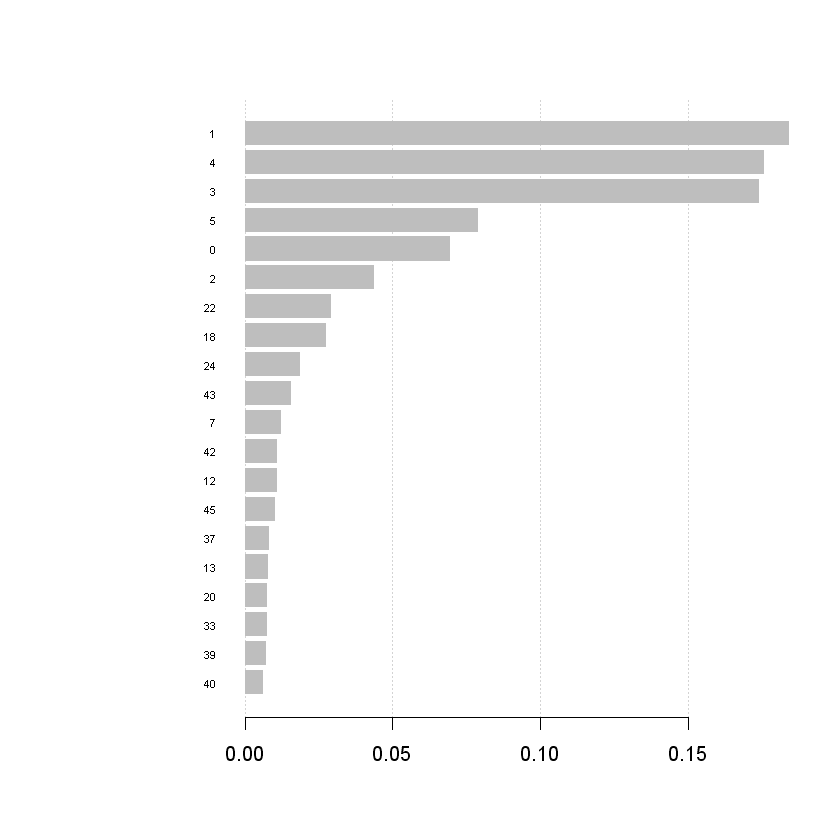

In [128]:
imp <- xgb.importance (model = mercari.model)
xgb.plot.importance (importance_matrix = imp[1:20])

In [150]:
mercari.predict <- as.data.frame(mercari.predict)

In [151]:
mercari.predict <- exp(mercari.predict)

In [152]:
mercari.final <- cbind(test$id,mercari.predict)

In [153]:
colnames(mercari.final) <- c("test_id", "price")
mercari.final <- data.frame(mercari.final)
mercari.final$test_id <- format(mercari.final$test_id, scientific=FALSE)
write.csv(mercari.final, "mercari.final.csv", row.names = F)